In [6]:
import pandas as pd
import numpy as np

ratings_list = [i.strip().split("::") for i in open('ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('movies.dat', 'r').readlines()]

ratings = pd.DataFrame(ratings_list, columns = ['user_id', 'movie_id', 'rating', 'ts'])
movies = pd.DataFrame(movies_list, columns = ['movie_id', 'title', 'genres'])
users = pd.DataFrame(users_list, columns = ['user_id', 'gender', 'age', 'occupation', 'zipcode'])

In [7]:
# Check the top 5 rows
print(ratings.head())


  user_id movie_id rating         ts
0       1     1193      5  978300760
1       1      661      3  978302109
2       1      914      3  978301968
3       1     3408      4  978300275
4       1     2355      5  978824291


In [8]:
# Check the file info
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id     1000209 non-null object
movie_id    1000209 non-null object
rating      1000209 non-null object
ts          1000209 non-null object
dtypes: object(4)
memory usage: 30.5+ MB
None


In [9]:
# Check the top 5 rows
print(users.head())

  user_id gender age occupation zipcode
0       1      F   1         10   48067
1       2      M  56         16   70072
2       3      M  25         15   55117
3       4      M  45          7   02460
4       5      M  25         20   55455


In [10]:
# Check the file info
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id       6040 non-null object
gender        6040 non-null object
age           6040 non-null object
occupation    6040 non-null object
zipcode       6040 non-null object
dtypes: object(5)
memory usage: 236.0+ KB
None


In [11]:

# Check the top 5 rows
print(movies.head())

  movie_id                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy


In [12]:
# Check the file info
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null object
title       3883 non-null object
genres      3883 non-null object
dtypes: object(3)
memory usage: 91.1+ KB
None


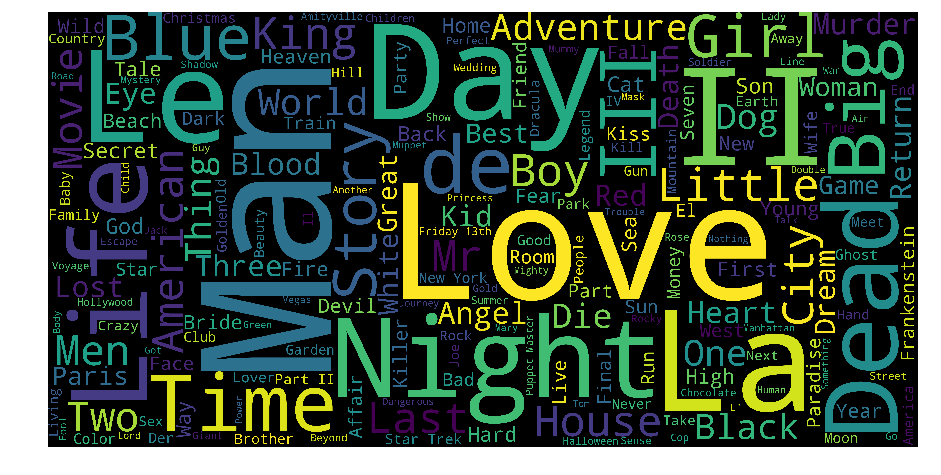

In [25]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=4000, width=8000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [15]:
# Get summary statistics of rating
ratings['rating'].describe()

count     1000209
unique          5
top             4
freq       348971
Name: rating, dtype: object

TypeError: unsupported operand type(s) for /: 'str' and 'int'

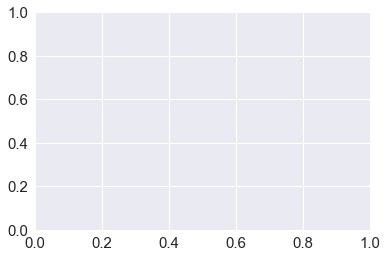

In [16]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

In [ ]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

In [ ]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

In [ ]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [17]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

In [19]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

In [20]:

# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [21]:
genre_recommendations('Good Will Hunting (1997)').head(20)


25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

In [22]:
genre_recommendations('Toy Story (1995)').head(20)


1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [23]:
genre_recommendations('Saving Private Ryan (1998)').head(20)


461            Heaven & Earth (1993)
1204        Full Metal Jacket (1987)
1214     Boat, The (Das Boot) (1981)
1222                    Glory (1989)
1545                G.I. Jane (1997)
1959      Saving Private Ryan (1998)
2358       Thin Red Line, The (1998)
2993         Longest Day, The (1962)
3559            Flying Tigers (1942)
3574    Fighting Seabees, The (1944)
3585    Guns of Navarone, The (1961)
3684             Patriot, The (2000)
40                Richard III (1995)
153            Beyond Rangoon (1995)
332         Walking Dead, The (1995)
523          Schindler's List (1993)
641        Courage Under Fire (1996)
967          Nothing Personal (1995)
979           Michael Collins (1996)
1074                  Platoon (1986)
Name: title, dtype: object